In [1]:
# # zip the file
# import zipfile
# zip_ref = zipfile.ZipFile("/content/gdrive/MyDrive/Processed Data/dataset_v1.1.zip", 'r')
# zip_ref.extractall("/content/gdrive/MyDrive/Processed Data/dataset")
# zip_ref.close()

In [2]:
import sys, os

# if 'google.colab' in sys.modules:
#     # mount google drive
#     from google.colab import drive
#     drive.mount('/content/gdrive')
#     # file_name = 'dataset_v1.1.zip'
#     path_to_file = '/content/gdrive/MyDrive/CS5242 Project/dataset'
#     print(path_to_file)

# local
path_to_file = '../dog_dataset'

In [3]:
# py_file_location = "/content/gdrive/MyDrive/Processed Data/dataset/dataset_v1.1"
# sys.path.append(os.path.abspath(py_file_location))

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from random import randint
import time
import utils
import os
import pandas as pd
import sys


In [5]:
train_data=torch.load(path_to_file+'/train_data_final.pt')
train_label=torch.load(path_to_file+'/train_label_final.pt')
test_data=torch.load(path_to_file+'/test_data_final.pt')
test_label=torch.load(path_to_file+'/test_label_final.pt')

In [6]:
print(train_data.size())
print(test_data.size())

torch.Size([979, 3, 64, 64])
torch.Size([100, 3, 64, 64])


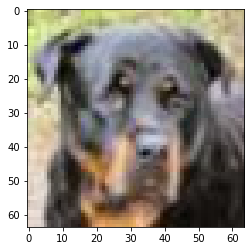

tensor(6)

In [7]:
utils.show(train_data[5])
train_label[5]

In [8]:
mean= train_data.mean()
print(mean)
std= train_data.std()
print(std)

tensor(0.4272)
tensor(0.2518)


In [9]:
class VGG_convnet(nn.Module):

    def __init__(self):

        super(VGG_convnet, self).__init__()

        # block 1:         3 x 64 x 64 --> 64 x 32 x 32        
        self.conv1a = nn.Conv2d(3,   64,  kernel_size=3, padding=1 )
        # self.conv1b = nn.Conv2d(64,  64,  kernel_size=3, padding=1 )
        self.pool1  = nn.MaxPool2d(2,2)

        # block 2:         64 x 32 x 32 --> 128 x 16 x 16
        self.conv2a = nn.Conv2d(64,  128, kernel_size=3, padding=1 )
        # self.conv2b = nn.Conv2d(128, 128, kernel_size=3, padding=1 )
        self.pool2  = nn.MaxPool2d(2,2)

        # block 3:         128 x 16 x 16 --> 256 x 8 x 8        
        self.conv3a = nn.Conv2d(128, 256, kernel_size=3, padding=1 )
        # self.conv3b = nn.Conv2d(256, 256, kernel_size=3, padding=1 )
        self.pool3  = nn.MaxPool2d(2,2)
        
        #block 4:          256 x 8 x 8 --> 512 x 4 x 4
        self.conv4a = nn.Conv2d(256, 512, kernel_size=3, padding=1 )
        self.pool4  = nn.MaxPool2d(2,2)

        #block 5:          512 x 4 x 4 --> 512 x 2 x 2
        self.conv5a = nn.Conv2d(512, 512, kernel_size=3, padding=1 )
        self.pool5  = nn.MaxPool2d(2,2)

        # linear layers:   512 x 2 x 2 --> 32768 --> 4096 --> 4096 --> 10
        self.linear1 = nn.Linear(2048, 4096)
        self.linear2 = nn.Linear(4096,4096)
        self.linear3 = nn.Linear(4096, 10)


    def forward(self, x):

        # block 1:         3 x 32 x 32 --> 64 x 16 x 16
        x = self.conv1a(x)
        x = torch.relu(x)
        # x = self.conv1b(x)
        # x = torch.relu(x)
        x = self.pool1(x)

        # block 2:         64 x 16 x 16 --> 128 x 8 x 8
        x = self.conv2a(x)
        x = torch.relu(x)
        # x = self.conv2b(x)
        # x = torch.relu(x)
        x = self.pool2(x)

        # block 3:         128 x 8 x 8 --> 256 x 4 x 4
        x = self.conv3a(x)
        x = torch.relu(x)
        # x = self.conv3b(x)
        # x = torch.relu(x)
        x = self.pool3(x)

        #block 4:          256 x 4 x 4 --> 512 x 2 x 2
        x = self.conv4a(x)
        x = torch.relu(x)
        x = self.pool4(x)

        #block 5:          256 x 4 x 4 --> 256 x 2 x 2
        x = self.conv5a(x)
        x = torch.relu(x)
        x = self.pool5(x)

        # linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
        x = x.view(-1, 2048)
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        x = torch.relu(x)
        x = self.linear3(x) 
        
        return x

In [10]:
# net = VGG_convnet()
# print(net)
# utils.display_num_param(net)

In [11]:
class LeNet5_convnet(nn.Module):

    def __init__(self):

        super(LeNet5_convnet, self).__init__()

        # CL1:   3 x 64 x 64  -->    50 x 64 x 64 
        self.conv1 = nn.Conv2d(3,   50,  kernel_size=3,  padding=1 )
        
        # MP1: 50 x 64 x 64 -->    50 x 32 x 32
        self.pool1  = nn.MaxPool2d(2,2)
        
        # CL2:   50 x 32 x 32  -->    100 x 32 x 32 
        self.conv2 = nn.Conv2d(50,  100,  kernel_size=3,  padding=1 )
        
        # MP2: 100 x 32 x 32 -->    100 x 16 x 16
        self.pool2 = nn.MaxPool2d(2,2)
        
        # LL1:   100 x 7 x 7 = 4900 -->  100 
        self.linear1 = nn.Linear(25600, 100)
        
        # LL2:   100  -->  10 
        self.linear2 = nn.Linear(100,10)


    def forward(self, x):

        # CL1:   28 x 28  -->    50 x 28 x 28 
        x = self.conv1(x)
        x = F.relu(x)
        
        # MP1: 50 x 28 x 28 -->    50 x 14 x 14
        x = self.pool1(x)
        
        # CL2:   50 x 14 x 14  -->    100 x 14 x 14
        x = self.conv2(x)
        x = F.relu(x)
        
        # MP2: 100 x 14 x 14 -->    100 x 7 x 7
        x = self.pool2(x)

        # LL1:   100 x 7 x 7 = 4900  -->  100 
        x = x.view(-1, 25600)
        x = self.linear1(x)
        x = F.relu(x)
        
        # LL2:   4900  -->  10 
        x = self.linear2(x)
    
        return x

In [12]:
net = LeNet5_convnet()
print(net)
utils.display_num_param(net)

LeNet5_convnet(
  (conv1): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=25600, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=10, bias=True)
)
There are 2607610 (2.61 million) parameters in this neural network


In [13]:
# device= torch.device("cuda")
device= torch.device("cpu")
print(device)

cpu


In [14]:
net = net.to(device)

mean = mean.to(device)

std = std.to(device)

In [15]:
criterion = nn.CrossEntropyLoss()
my_lr= 0.01
bs= 10

In [16]:
def eval_on_test_set():

    running_error=0
    num_batches=0

    for i in range(0,100,bs):

        minibatch_data =  test_data[i:i+bs]
        minibatch_label= test_label[i:i+bs]

        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        inputs = (minibatch_data - mean)/std
        # inputs = minibatch_data

        scores=net( inputs ) 

        error = utils.get_error( scores , minibatch_label)

        running_error += error.item()

        num_batches+=1

    total_error = running_error/num_batches
    print( 'error rate on test set =', total_error*100 ,'percent')

In [17]:
start=time.time()

for epoch in range(1,100):
    
    # divide the learning rate by 2 at epoch 10, 14 and 18
    if epoch == 5: 
      my_lr = my_lr/2
    
    # create a new optimizer at the beginning of each epoch: give the current learning rate.   
    optimizer=torch.optim.SGD( net.parameters() , lr=my_lr )
        
    # set the running quatities to zero at the beginning of the epoch
    running_loss=0
    running_error=0
    num_batches=0
    
    # set the order in which to visit the image from the training set
    shuffled_indices=torch.randperm(979)
 
    for count in range(0,979,bs):
    
        # Set the gradients to zeros
        optimizer.zero_grad()
        
        # create a minibatch       
        indices=shuffled_indices[count:count+bs]
        minibatch_data =  train_data[indices]
        minibatch_label=  train_label[indices]
        
        # send them to the gpu
        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        # normalize the minibatch (this is the only difference compared to before!)
        inputs = (minibatch_data - mean)/std
        # inputs = minibatch_data
        
        # tell Pytorch to start tracking all operations that will be done on "inputs"
        inputs.requires_grad_()

        # forward the minibatch through the net 
        # scores=net( inputs ) 
        scores=net( inputs )

        # Compute the average of the losses of the data points in the minibatch
        loss =  criterion( scores , minibatch_label) 
        
        # backward pass to compute dL/dU, dL/dV and dL/dW   
        loss.backward()

        # do one step of stochastic gradient descent: U=U-lr(dL/dU), V=V-lr(dL/dU), ...
        optimizer.step()
        

        # START COMPUTING STATS
        
        # add the loss of this batch to the running loss
        running_loss += loss.detach().item()
        
        # compute the error made on this batch and add it to the running error       
        error = utils.get_error( scores.detach() , minibatch_label)
        running_error += error.item()
        
        num_batches+=1        
    
    
    # compute stats for the full training set
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed = (time.time()-start)/60
    
    if epoch%10 == 9:
        print('epoch=',epoch, '\t time=', elapsed,'min','\t lr=', my_lr  ,'\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
        eval_on_test_set() 
        print(' ')

/Users/abby/miniconda3/envs/deeplearn_course/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1623459064158/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch= 9 	 time= 1.299053164323171 min 	 lr= 0.005 	 loss= 0.9997741765513712 	 error= 34.43310625699102 percent
error rate on test set = 55.00000059604645 percent
 
epoch= 19 	 time= 2.725022049744924 min 	 lr= 0.005 	 loss= 0.10701958494907131 	 error= 1.3265308068723094 percent
error rate on test set = 50.0 percent
 
epoch= 29 	 time= 4.148954729239146 min 	 lr= 0.005 	 loss= 0.008090506127218202 	 error= 0.0 percent
error rate on test set = 46.00000023841858 percent
 
epoch= 39 	 time= 5.565256015459696 min 	 lr= 0.005 	 loss= 0.003772597826485123 	 error= 0.0 percent
error rate on test set = 48.00000011920929 percent
 
epoch= 49 	 time= 6.988443915049235 min 	 lr= 0.005 	 loss= 0.0023861678123559653 	 error= 0.0 percent
error rate on test set = 46.00000023841858 percent
 
epoch= 59 	 time= 8.441501911481222 min 	 lr= 0.005 	 loss= 0.0017094870605173387 	 error= 0.0 percent
error rate on test set = 46.99999988079071 percent
 
epoch= 69 	 time= 9.877084147930145 min 	 lr= 0.005 	 lo

tensor(5)


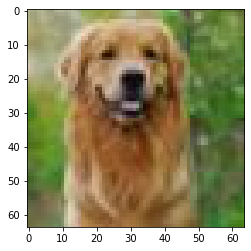

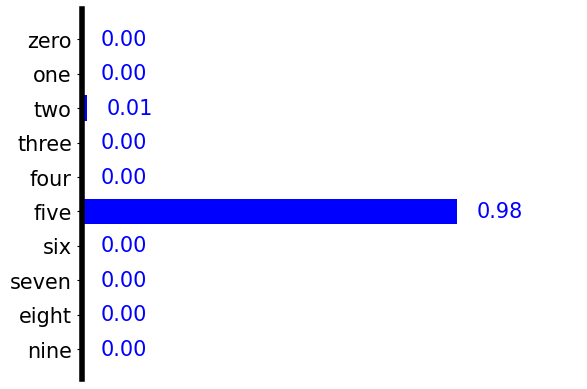

In [18]:
# choose a picture at random
idx=randint(0, 100)
im=test_data[idx]
print(test_label[idx])

# diplay the picture
utils.show(im)

# send to device, rescale, and view as a batch of 1 
im = im.to(device)
im= (im-mean) / std
im=im.view(3,64,64).unsqueeze(dim=0)

# feed it to the net and display the confidence scores
scores =  net(im) 
probs= F.softmax(scores, dim=1)
utils.show_prob_mnist(probs.cpu())

In [19]:
dog_dict = {
    'affenpinscher':0,
    'beagle':1,
    'boxer':2,
    'chihuahua':3,
    'frenchbulldog':4,
    'goldenretriever':5,
    'rottweiler':6,
    'schnauzer':7,
    'sheepdog':8,
    'spaniel':9
}